Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1684 files belonging to 2 classes.
Class names: ['Non-standard', 'Standard']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           2,562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6798 - loss: 0.6836 - val_accuracy: 0.8188 - val_loss: 0.4215
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7956 - loss: 0.4817 - val_accuracy: 0.8250 - val_loss: 0.4163
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8342 - loss: 0.4071 - val_accuracy: 0.8125 - val_loss: 0.4628
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8402 - loss: 0.3876 - val_accuracy: 0.8313 - val_loss: 0.4024
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8578 - loss: 0.3621 - val_accuracy: 0.8062 - val_loss: 0.4832
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8422 - loss: 0.3481 - val_accuracy: 0.8188 - val_loss: 0.4276
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8532 - loss: 0.3916 - val_accuracy: 0.8313 - val_loss: 0.4000
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8586 - loss: 0.3709 - val_accuracy: 0.7812 - v

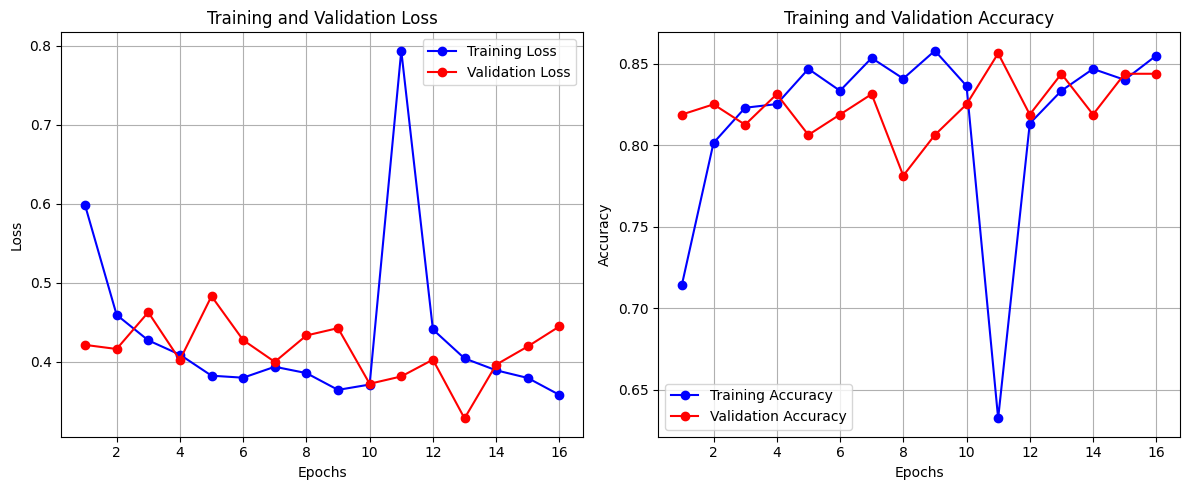

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Parameters
batch_size = 16
img_height = 224
img_width = 224
data_dir = '/content/drive/MyDrive/prenatal'

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)
class_names = dataset.class_names
print(f"Class names: {class_names}")

# Split dataset into train, val, test
train_size = 0.8
val_size = 0.1
test_size = 0.1

total_count = len(dataset)
train_count = int(total_count * train_size)
val_count = int(total_count * val_size)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count).take(val_count)
test_ds = dataset.skip(train_count + val_count)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Apply augmentation only on training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Prefetch data for optimization
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load MobileNetV2 as the base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,  # Exclude the classification head
                         weights='imagenet')  # Use pre-trained weights on ImageNet

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector per image
    layers.Dropout(0.2),  # Add dropout to reduce overfitting
    layers.Dense(len(class_names), activation='softmax')  # Classification layer
])



# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Unfreeze some base model layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this point

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=history.epoch[-1])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training and fine-tuning curves
def plot_training_curves(history, history_fine=None):
    # Extract data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    if history_fine:
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
        accuracy += history_fine.history['accuracy']
        val_accuracy += history_fine.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training and fine-tuning curves
plot_training_curves(history, history_fine)
